# Predictive Modeling for Ultimate Technologies

The goal of this notebook is to analyze data and create a predictive model that is useful in predicting rider retention. 

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

First, let's import the data and understand it so our model is better prepped.

In [2]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
df = pd.DataFrame(data)

In [3]:
df

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0
6,3.95,4.0,NaN,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0
8,4.36,5.0,4.5,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0
9,2.37,5.0,NaN,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0


First, we want to convert all dates to datetime

In [4]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

Next, let's look at the dataframe as a whole

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


One alterior goal is to find the fraction of the drivers who were retained. This will help us solve the rider retention problem, as it created our key predictor. 

In [6]:
df['last_trip_date'].describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

Looking at top, we see that the last day was on 2014-06-29. Ultimate defines rider retention aas the following: 'we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.'So we want to keep our calculations within the month of june. Let's divide the number of trips after June 1st by total number of users who made trips after June 1st.

In [7]:
retained = ((df.last_trip_date >= '2014-06-01').sum() / (df.last_trip_date >= '2014-06-01').count()) * 100
retained

37.608000000000004

This means about 38% of users were retained. Let's create a column identifying all the retained users. 

In [8]:
df['retained'] = (df.last_trip_date >= '2014-06-01')*1
df

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0,1
6,3.95,4.0,NaN,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0,0
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0,0
8,4.36,5.0,4.5,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0,0
9,2.37,5.0,NaN,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0,0


Now that we have this data, let's try and find and correlations between retainment and any other catagorical values. 

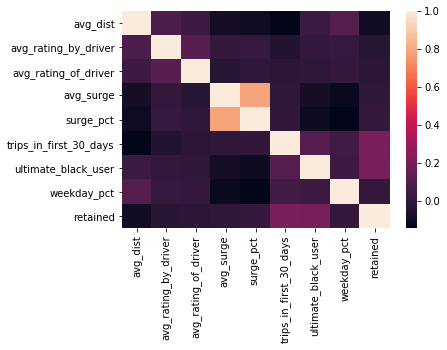

In [9]:
fig = plt.figure()
ax = plt.subplot(111)
corr = df.corr()
ax = sns.heatmap(corr)
plt.show()

In [10]:
corr['retained'].sort_values(ascending=False)

retained                  1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_of_driver     -0.011653
avg_rating_by_driver     -0.026791
avg_dist                 -0.092780
Name: retained, dtype: float64

As we notice by both the heatmap and the list, we can see that an ultimate black user has a high correlation. Let's also start adding city and phone into our data to see if that impacts retention.  

In [11]:
print(df.city.value_counts())
print(df.city.value_counts().sum())
print(df.phone.value_counts())
print(df.phone.value_counts().sum())


Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64
50000
iPhone     34582
Android    15022
Name: phone, dtype: int64
49604


Checking the city and phone columns, we find that there are some null values in phone. Let's create another column for those, since they may be unspecified phones.

In [13]:
df.phone.fillna('Other', inplace=True)
print(df.phone.value_counts())
df.phone.value_counts().sum()

iPhone     34582
Android    15022
Other        396
Name: phone, dtype: int64


50000

Now that there are no null values, we can one-hot encode both City and Phone so that way it is ready for modeling. 

In [14]:
cities_ohe = pd.get_dummies(df['city'])
phones_ohe = pd.get_dummies(df['phone'])

In [15]:
df = df.join(cities_ohe).join(phones_ohe)
df.drop(['city', 'phone'], axis=1, inplace=True)

In [16]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,Astapor,King's Landing,Winterfell,Android,Other,iPhone
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,1,0,1,0,0,0,1
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,0,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,0,1,0,0,0,0,1
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,1,0,1,0,0,0,1
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,0,0,1,1,0,0


Let's look at the correlation map again with a focus on phones and cities.

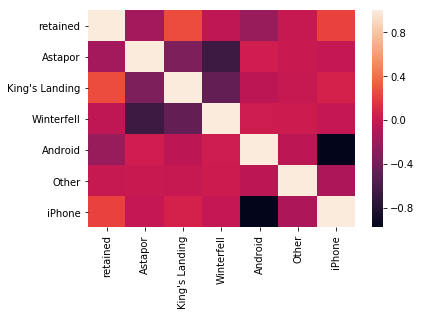

In [17]:
categories = df.iloc[:,-7:]
fig = plt.figure()
ax = plt.subplot(111)
corr = categories.corr()
ax = sns.heatmap(corr)
plt.show()

In [18]:
corr['retained'].sort_values(ascending=False)

retained          1.000000
King's Landing    0.262284
iPhone            0.225244
Other            -0.007419
Winterfell       -0.046611
Astapor          -0.174655
Android          -0.225464
Name: retained, dtype: float64

We see that being from King's Landing and using an iPhone are associated with being retained. Being from Astapor or Winterfell or using an Android are negatively associated with retention.

Finally, let's look at last trip date and see if this correlates with retention.

In [19]:
ref = min(df['last_trip_date'])
df['last_trip_date'] = (df['last_trip_date'] - ref).dt.days + 1

In [20]:
df['last_trip_date'].corr(df['retained'])

0.7808374961936146

To no one's surpise, this is highly correlative. Next, let's make Ultimate_Black_User an integer. This will help with the model accuracy, and will cause it to show up in .describe().

In [21]:
df['ultimate_black_user'] = df['ultimate_black_user']*1

Finally, let's get rid of any NaN values.

In [22]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median(), inplace=True)

In [23]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,Astapor,King's Landing,Winterfell,Android,Other,iPhone
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.779050,4.650038,1.074764,109.334780,8.849536,2.278200,0.37708,60.926084,0.376080,0.330680,0.202600,0.466720,0.300440,0.007920,0.691640
std,5.707357,0.445974,0.575601,0.222336,61.718985,19.958811,3.792684,0.48466,37.081503,0.484405,0.470463,0.401941,0.498896,0.458454,0.088642,0.461821
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,45.000000,0.000000,0.000000,0.00000,33.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.880000,5.000000,4.900000,1.000000,128.000000,0.000000,1.000000,0.00000,66.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,6.940000,5.000000,5.000000,1.050000,169.000000,8.600000,3.000000,1.00000,100.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,160.960000,5.000000,5.000000,8.000000,182.000000,100.000000,125.000000,1.00000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,Astapor,King's Landing,Winterfell,Android,Other,iPhone
0,3.67,5.0,4.7,1.10,168,2014-01-25,15.4,4,1,46.2,1,0,1,0,0,0,1
1,8.26,5.0,5.0,1.00,125,2014-01-29,0.0,0,0,50.0,0,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,7,2014-01-06,0.0,3,0,100.0,0,1,0,0,0,0,1
3,2.36,4.9,4.6,1.14,180,2014-01-10,20.0,9,1,80.0,1,0,1,0,0,0,1
4,3.13,4.9,4.4,1.19,74,2014-01-27,11.8,14,0,82.4,0,0,0,1,1,0,0


At this point, we have looked at relationships between every feature and our created column 'retained'. This helps us understand the data and will help us when moving forward with creating our model. The data is now ready for modeling.

First, we want to drop date related columns, since those will not be helpful to our model.

In [26]:
# drop features related to target variable created before
df.drop('last_trip_date', axis=1, inplace=True)
df.drop('signup_date', axis=1, inplace=True)

Next, we want to assign our target variable and also drop this column from our data.

In [28]:
y= df['retained'].values
df = df.drop('retained', axis=1)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,Astapor,King's Landing,Winterfell,Android,Other,iPhone
0,3.67,5.0,4.7,1.10,15.4,4,1,46.2,0,1,0,0,0,1
1,8.26,5.0,5.0,1.00,0.0,0,0,50.0,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,0.0,3,0,100.0,1,0,0,0,0,1
3,2.36,4.9,4.6,1.14,20.0,9,1,80.0,0,1,0,0,0,1
4,3.13,4.9,4.4,1.19,11.8,14,0,82.4,0,0,1,1,0,0


Then, we want to set the rest of our data to a variable.

In [29]:
X = df[df!='retained'].values

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Now that all our data is properally set, we can split the data.

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

Let's use Logistic Regression to start. This is because we want to classify if a user is more likely to be retained, which fits well with the purpose of LogisticRegression.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr = LogisticRegression()
lr.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

This model looks good, but let's test the model accuracy to be sure.

In [32]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

10-fold cross validation average accuracy: 0.717


Now that our model is trained we can use it to make a prediction and compare the prediction accuracy to our model accuracy. 

In [33]:
y_pred = lr.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.72


The average accuracy remains very close to the Logistic Regression model accuracy; hence, we can conclude that our model generalizes well. Let's look at where the model got confused

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[10660  1853]
 [ 3778  3709]]


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79     12513
           1       0.67      0.50      0.57      7487

   micro avg       0.72      0.72      0.72     20000
   macro avg       0.70      0.67      0.68     20000
weighted avg       0.71      0.72      0.71     20000



Overall, we can say that our model has done a pretty good job. Next, we are going to repeat the process but with Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)
ypred = model.predict(X_test)

In [37]:

from sklearn.metrics import accuracy_score
predicted = model.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(accuracy)

0.7604


In [38]:
#Classification Report for Random Forest
from sklearn import metrics
print(metrics.classification_report(ypred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      7965
           1       0.66      0.69      0.68      4535

   micro avg       0.76      0.76      0.76     12500
   macro avg       0.74      0.74      0.74     12500
weighted avg       0.76      0.76      0.76     12500



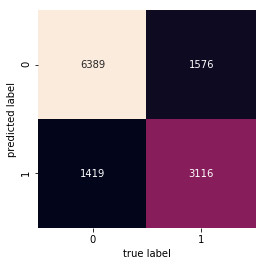

In [39]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Features sorted by their score:
[(0.3014, 'avg_dist'), (0.1807, 'avg_rating_by_driver'), (0.1126, 'weekday_pct'), (0.082, 'avg_rating_of_driver'), (0.0673, 'trips_in_first_30_days'), (0.0664, "King's Landing"), (0.0592, 'surge_pct'), (0.0433, 'avg_surge'), (0.0267, 'ultimate_black_user'), (0.0255, 'Android'), (0.0125, 'Astapor'), (0.0112, 'iPhone'), (0.0099, 'Winterfell'), (0.0012, 'Other')]
Feature ranking:
1. feature 0 (0.287988)
2. feature 7 (0.152986)
3. feature 5 (0.099021)
4. feature 1 (0.095850)
5. feature 2 (0.086690)
6. feature 4 (0.067379)
7. feature 3 (0.054515)
8. feature 9 (0.046484)
9. feature 6 (0.035319)
10. feature 13 (0.024224)
11. feature 11 (0.022759)
12. feature 8 (0.015783)
13. feature 10 (0.010322)
14. feature 12 (0.000680)
1. feature 0 (0.287988)
2. feature 7 (0.152986)
3. feature 5 (0.099021)
4. feature 1 (0.095850)
5. feature 2 (0.086690)
6. feature 4 (0.067379)
7. feature 3 (0.054515)
8. feature 9 (0.046484)
9. feature 6 (0.035319)
10. feature 13 (0.024224)
1

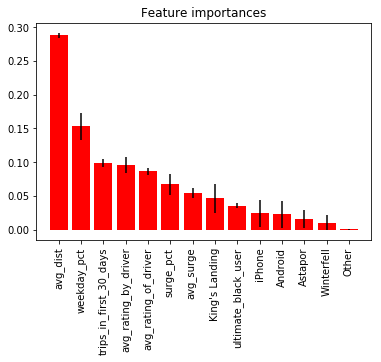

In [40]:
# Explore feature importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
names = df.columns.values

rf = RandomForestRegressor()
rf.fit(X, y)
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             
             reverse=True))

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=200,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
for f in range(X.shape[1]):
    indices = np.argsort(importances)[::-1]
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), names[indices], rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

Overall, we can conclude that the random forest model has a higher accuracy than the logistic regression, so random forest will be our optimal model with 76% accuracy shown in the confusion matrix. Under this model, the feature importance provide the level of importance of predictors on estimating retained customers. The average distance in miles per trip taken in the first 30 days after signup, avg_dist, is the most importan feature, so Ultimate black can provide chip or point system for their customers who collecting more points as long as they go distance with Ultimate black more.